# MNIST Digit Recognizer

In this notebook we work with the famous MNIST digits dataset. Our task will be to use a convolutional neural network to correctly identify digits provided as greyscale images. We will use two different apporaches: one with an image data generator and one without. In the end we find that the approach using an image data generator is more accurate, which is not terribly surprising. Let's get started!

## Imports
Let's first import the standard libraries.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid') # preferred seaborn aesthetic
%matplotlib inline

The dataset is built into the tensorflow module. Let's import it.

In [3]:
from tensorflow.keras.datasets import mnist

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

## EDA
Let's take a look at our data.

In [5]:
print('Shape of training data:', X_train.shape)
print('Shape of test data:', X_test.shape)

Shape of training data: (60000, 28, 28)
Shape of test data: (10000, 28, 28)


Our training set consists of 28 by 28 images with 60 000 images in total. Our test set has 10 000 images. Let's make sure all images in our set are indeed 28 by 28.

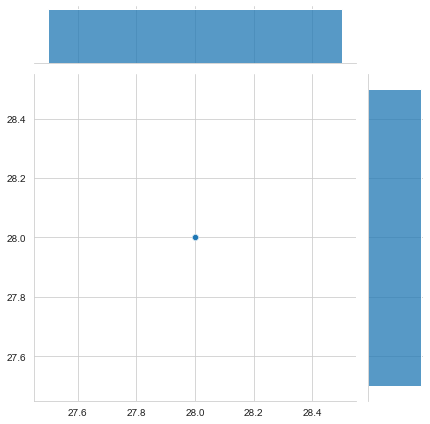

In [6]:
# initialize variables
widths = []
heights = []

# record the widths and heights of the images in our training set
for i in range(0, X_train.shape[0]):
    widths.append(X_train[i].shape[0])
    heights.append(X_train[i].shape[1])
    
# create a jointplot of image sizes
sns.jointplot(x = widths, y = heights)

Every image in our training set is indeed 28 by 28.

Let's take a look at an image in our training set.

This number is 4


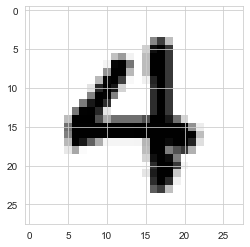

In [72]:
# choose a random number
num = np.random.randint(0,len(X_train)+1)

# display the image
plt.imshow(X_train[num], cmap = 'binary')
print('This number is', y_train[num])

## One-Hot Encoding the Labels

Before we create our model we should one-hot encode the labels. Indeed, currently the labels are the digits themselves.

In [8]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Let's one-hot encode.

In [9]:
from tensorflow.keras.utils import to_categorical

In [10]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

## Using an Image Data Generator

We use an image data generator to increase the robustness of our classifier. By applying random transformations to our images we generalize our model, thereby reducing overfitting.

Before we use an image data generator we will need to rescale and reshape our data.

In [11]:
# rescale data
X_test = X_test / X_train.max()
X_train = X_train / X_train.max()

# reshape data
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

Now we create our image data generator.

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [61]:
image_gen = ImageDataGenerator(rotation_range = 10, # rotate by up to 10 degrees
                            width_shift_range = 0.05, # shift width by up to 5% 
                            height_shift_range = 0.05, # shift height by up to 5%
                            shear_range = 10, # shear by up to 10 degrees
                            zoom_range = 0.05, # zoom by up to 5%
                            horizontal_flip = False, # do not flip images horizontally
                            vertical_flip = False) # do not flip images vertically

Let's take a look at how our image data generator changes our images. First we need to rescale and reshape our data.

Text(0.5, 1.0, 'Image After Transformation')

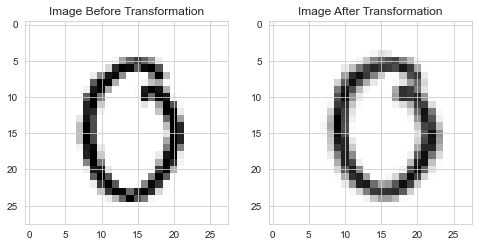

In [62]:
# get a random number
num = np.random.randint(0, len(X_train) + 1)

# display an image both before and after a transformation
plt.figure(figsize = (8, 4))

# plot image before transformation
plt.subplot(1, 2, 1)
plt.imshow(X_train[num], cmap = 'binary')
plt.title('Image Before Transformation')

# plot image after transformation
plt.subplot(1, 2, 2)
plt.imshow(image_gen.random_transform(X_train[num]), cmap = 'binary')
plt.title('Image After Transformation')

## Predictions with an Image Data Generator

Now let's create our model to recognize digits in the test set. We use a convolutional neural network.

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [63]:
# create the model
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = 4, input_shape = (28, 28, 1), activation = 'relu'))
model.add(MaxPool2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 4, input_shape = (28, 28, 1), activation = 'relu'))
model.add(MaxPool2D(pool_size = 2))
model.add(Flatten())
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 10, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# perform a train-test split
X_trainer, X_tester, y_trainer, y_tester = train_test_split(X_train, y_train, test_size = 0.2, random_state = 18,
                                                            stratify = y_train)

# one-hot encode y_trainer and y_tester
y_trainer_cat = to_categorical(y_trainer)
y_tester_cat = to_categorical(y_tester)

# apply the image data generator to the training and validation sets
image_gen_train = image_gen.flow(x = X_trainer, y = y_trainer_cat, shuffle = True)
image_gen_test = image_gen.flow(x = X_tester, y = y_tester_cat, shuffle = True)

# fit the model
stop = EarlyStopping(patience = 3, restore_best_weights = True)
model.fit(x = image_gen_train, epochs = 1000, validation_data = image_gen_test, callbacks = [stop])

# make predictions
pred_probs = model.predict(X_tester)
pred = [np.argmax(i) for i in pred_probs]

# print metrics
print(classification_report(y_tester, pred))
print(confusion_matrix(y_tester, pred))

Epoch 1/1000
1500/1500 [==============================] - 28s 18ms/step - loss: 0.5407 - accuracy: 0.8276 - val_loss: 0.0976 - val_accuracy: 0.9693
Epoch 2/1000
1500/1500 [==============================] - 28s 19ms/step - loss: 0.1159 - accuracy: 0.9639 - val_loss: 0.0567 - val_accuracy: 0.9813
Epoch 3/1000
1500/1500 [==============================] - 28s 19ms/step - loss: 0.0834 - accuracy: 0.9748 - val_loss: 0.0562 - val_accuracy: 0.9818
Epoch 4/1000
1500/1500 [==============================] - 28s 19ms/step - loss: 0.0673 - accuracy: 0.9793 - val_loss: 0.0455 - val_accuracy: 0.9854
Epoch 5/1000
1500/1500 [==============================] - 28s 19ms/step - loss: 0.0615 - accuracy: 0.9810 - val_loss: 0.0451 - val_accuracy: 0.9872
Epoch 6/1000
1500/1500 [==============================] - 28s 19ms/step - loss: 0.0572 - accuracy: 0.9825 - val_loss: 0.0444 - val_accuracy: 0.9862
Epoch 7/1000
1500/1500 [==============================] - 28s 19ms/step - loss: 0.0535 - accuracy: 0.9843 - val_

Our network seems to work rather well. How many images were misclassified?

In [64]:
print('Number of misclassified images in validation set:', np.sum([y_tester != pred]))
print('Total number of images in validation set:', len(X_tester))
print('Percentage of misclassified images:', str(100 * np.sum([y_tester != pred]) / len(X_tester))+'%')

Number of misclassified images in validation set: 79
Total number of images in validation set: 12000
Percentage of misclassified images: 0.6583333333333333%


This model performs quite well so we will use it to predict on the test set.

In [71]:
# create the model
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = 4, input_shape = (28, 28, 1), activation = 'relu'))
model.add(MaxPool2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 4, input_shape = (28, 28, 1), activation = 'relu'))
model.add(MaxPool2D(pool_size = 2))
model.add(Flatten())
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 10, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# apply the image data generator to the training set
image_gen_train = image_gen.flow(x = X_train, y = y_train_cat, shuffle = True)

# fit the model
model.fit(x = image_gen_train, epochs = 10)

# make predictions
pred_probs = model.predict(X_test)
pred = [np.argmax(i) for i in pred_probs]

# print metrics
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))
print('Number of misclassified images in test set:', np.sum([y_test != pred]))
print('Total number of images in test set:', len(X_test))
print('Percentage of misclassified images:', str(100 * np.sum([y_test != pred]) / len(X_test))+'%')

Epoch 1/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.5109 - accuracy: 0.8350
Epoch 2/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1066 - accuracy: 0.9674
Epoch 3/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0748 - accuracy: 0.9778
Epoch 4/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0637 - accuracy: 0.9803
Epoch 5/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0521 - accuracy: 0.9839
Epoch 6/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0523 - accuracy: 0.9837
Epoch 7/10
1875/1875 [==============================] - 40s 21ms/step - loss: 0.0478 - accuracy: 0.9856
Epoch 8/10
1875/1875 [==============================] - 40s 21ms/step - loss: 0.0526 - accuracy: 0.98480s - loss: 0.0527 - 
Epoch 9/10
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0388 - accuracy: 0.9880
Epoch 10/10
1875/1875 [=====================

The convolutional neural network with an image data generator works rather well! Let's see how well a convolutional neural network works without an image data generator.

## Predictions without an Image Data Generator

Since the MNIST dataset is already rather large and clean it is entirely possible that a convolutional neural network will perform well, and perhaps better, without a data image generator. Let's see if this is the case.

In [68]:
# create the model
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = 4, input_shape = (28, 28, 1), activation = 'relu'))
model.add(MaxPool2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 4, input_shape = (28, 28, 1), activation = 'relu'))
model.add(MaxPool2D(pool_size = 2))
model.add(Flatten())
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 10, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# perform a train-test split
X_trainer, X_tester, y_trainer, y_tester = train_test_split(X_train, y_train, test_size = 0.2, random_state = 18,
                                                            stratify = y_train)

# one-hot encode y_trainer and y_tester
y_trainer_cat = to_categorical(y_trainer)
y_tester_cat = to_categorical(y_tester)

# fit the model
stop = EarlyStopping(patience = 3, restore_best_weights = True)
model.fit(x = X_trainer, y = y_trainer_cat, epochs = 1000, validation_data = (X_tester, y_tester_cat), callbacks = [stop])

# make predictions
pred_probs_no_gen = model.predict(X_tester)
pred_no_gen = [np.argmax(i) for i in pred_probs_no_gen]

# print metrics
print(classification_report(y_tester, pred_no_gen))
print(confusion_matrix(y_tester, pred_no_gen))

Epoch 1/1000
1500/1500 [==============================] - 27s 18ms/step - loss: 0.4274 - accuracy: 0.8629 - val_loss: 0.0655 - val_accuracy: 0.9795
Epoch 2/1000
1500/1500 [==============================] - 25s 17ms/step - loss: 0.0805 - accuracy: 0.9757 - val_loss: 0.0547 - val_accuracy: 0.9818
Epoch 3/1000
1500/1500 [==============================] - 25s 16ms/step - loss: 0.0530 - accuracy: 0.9833 - val_loss: 0.0446 - val_accuracy: 0.9862
Epoch 4/1000
1500/1500 [==============================] - 25s 17ms/step - loss: 0.0417 - accuracy: 0.9873 - val_loss: 0.0367 - val_accuracy: 0.9886
Epoch 5/1000
1500/1500 [==============================] - 25s 16ms/step - loss: 0.0331 - accuracy: 0.9898 - val_loss: 0.0388 - val_accuracy: 0.9873
Epoch 6/1000
1500/1500 [==============================] - 24s 16ms/step - loss: 0.0300 - accuracy: 0.9908 - val_loss: 0.0311 - val_accuracy: 0.9902
Epoch 7/1000
1500/1500 [==============================] - 25s 17ms/step - loss: 0.0242 - accuracy: 0.9919 - val_

How many images were misclassified in this case?

In [69]:
print('Number of misclassified images in validation set:', np.sum([y_tester != pred_no_gen]))
print('Total number of images in validation set:', len(X_tester))
print('Percentage of misclassified images:', str(100 * np.sum([y_tester != pred_no_gen]) / len(X_tester))+'%')

Number of misclassified images in validation set: 118
Total number of images in validation set: 12000
Percentage of misclassified images: 0.9833333333333333%


On the validation set the convolutional neural network without an image data generator does not perform as well as the neural network with said generator. Perhaps the story is different on the test set.

In [70]:
# create the model
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = 4, input_shape = (28, 28, 1), activation = 'relu'))
model.add(MaxPool2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 4, input_shape = (28, 28, 1), activation = 'relu'))
model.add(MaxPool2D(pool_size = 2))
model.add(Flatten())
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 10, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# fit the model
model.fit(x = X_train, y = y_train_cat, epochs = 6)

# make predictions
pred_probs_no_gen = model.predict(X_test)
pred_no_gen = [np.argmax(i) for i in pred_probs_no_gen]

# print metrics
print(classification_report(y_test, pred_no_gen))
print(confusion_matrix(y_test, pred_no_gen))
print('Number of misclassified images in test set:', np.sum([y_test != pred_no_gen]))
print('Total number of images in test set:', len(X_test))
print('Percentage of misclassified images:', str(100 * np.sum([y_test != pred_no_gen]) / len(X_test))+'%')

Epoch 1/6
1875/1875 [==============================] - 32s 17ms/step - loss: 0.3893 - accuracy: 0.8777
Epoch 2/6
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0667 - accuracy: 0.9794
Epoch 3/6
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0493 - accuracy: 0.9848
Epoch 4/6
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0371 - accuracy: 0.9890
Epoch 5/6
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0315 - accuracy: 0.9902
Epoch 6/6
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0254 - accuracy: 0.9920
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
   

While the result is quite good, the convolutional neural network with the image data generator still performed better.